# Technology Sales Forecasting

Import modules to be used

In [1]:
%%capture
# pip install this package to view the summary of model  
# used jupyter install due to it does not have conda version
# %%capture suppress information of torchsummaryX installation
!pip install torchsummaryX

In [2]:
%matplotlib inline

from pathlib import Path
import sys
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Dataset used is the Superstore sales data, which contains several categories. For this project, we are focusing on forecasting the technology sales data.

In [3]:
#Import data
df = pd.read_csv("../../Dataset/superstore.csv")
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2.0,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3.0,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2.0,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5.0,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2.0,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,Person,Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10292,Anna Andreadi,West,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10293,Chuck Magee,East,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10294,Kelly Williams,Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Get technology categories
technology = df.loc[df['Category'] == 'Technology']
technology

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7,8,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032.0,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6.0,0.2,90.7152
11,12,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032.0,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.424,4.0,0.2,68.3568
19,20,CA-2014-143336,8/27/2014,9/1/2014,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,...,94109.0,West,TEC-PH-10001949,Technology,Phones,Cisco SPA 501G IP Phone,213.480,3.0,0.2,16.0110
26,27,CA-2016-121755,1/16/2016,1/20/2016,Second Class,EH-13945,Eric Hoffmann,Consumer,United States,Los Angeles,...,90049.0,West,TEC-AC-10003027,Technology,Accessories,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,90.570,3.0,0.0,11.7741
35,36,CA-2016-117590,12/8/2016,12/10/2016,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080.0,Central,TEC-PH-10004977,Technology,Phones,GE 30524EE4,1097.544,7.0,0.2,123.4737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,9984,US-2016-157728,9/22/2016,9/28/2016,Standard Class,RC-19960,Ryan Crowe,Consumer,United States,Grand Rapids,...,49505.0,Central,TEC-PH-10001305,Technology,Phones,Panasonic KX TS208W Corded phone,97.980,2.0,0.0,27.4344
9986,9987,CA-2016-125794,9/29/2016,10/3/2016,Standard Class,ML-17410,Maris LaWare,Consumer,United States,Los Angeles,...,90008.0,West,TEC-AC-10003399,Technology,Accessories,Memorex Mini Travel Drive 64 GB USB 2.0 Flash ...,36.240,1.0,0.0,15.2208
9987,9988,CA-2017-163629,11/17/2017,11/21/2017,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,30605.0,South,TEC-AC-10001539,Technology,Accessories,Logitech G430 Surround Sound Gaming Headset wi...,79.990,1.0,0.0,28.7964
9988,9989,CA-2017-163629,11/17/2017,11/21/2017,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,30605.0,South,TEC-PH-10004006,Technology,Phones,Panasonic KX - TS880B Telephone,206.100,5.0,0.0,55.6470


Data Preprocessing
Remove unnecessary columns, check missing values, aggregate sales by date, etc.

In [5]:
#Remove unnecessary columns, only need order date and sales data
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
technology.drop(cols, axis=1, inplace=True)
technology

,Order Date,Sales
7,6/9/2014,907.152
11,6/9/2014,911.424
19,8/27/2014,213.480
26,1/16/2016,90.570
35,12/8/2016,1097.544
...,...,...
9983,9/22/2016,97.980
9986,9/29/2016,36.240
9987,11/17/2017,79.990
9988,11/17/2017,206.100


In [6]:
#Sort list based on Order Date by ascending order 
technology = technology.sort_values('Order Date')
technology

,Order Date,Sales
4667,1/10/2016,69.980
1027,1/11/2016,15.588
9797,1/12/2015,235.188
9800,1/12/2015,107.118
9798,1/12/2015,26.376
...,...,...
3597,9/9/2014,64.704
7718,9/9/2017,159.960
1219,9/9/2017,1931.958
1216,9/9/2017,95.880


In [7]:
#Check for missing values
technology.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [8]:
#Accumulates total sales with those that have same order date
technology = technology.groupby('Order Date')['Sales'].sum().reset_index()
technology

,Order Date,Sales
0,1/10/2016,69.980
1,1/11/2016,15.588
2,1/12/2015,379.066
3,1/13/2014,646.740
4,1/14/2017,528.688
...,...,...
819,9/8/2014,8680.728
820,9/8/2016,152.712
821,9/8/2017,948.016
822,9/9/2014,1500.210


In [9]:
#Change default index to be time series data index
technology['Order Date'] = pd.to_datetime(technology['Order Date'])
technology.set_index('Order Date', inplace=True)
technology

,Sales
Order Date,
2016-01-10,69.980
2016-01-11,15.588
2015-01-12,379.066
2014-01-13,646.740
2017-01-14,528.688
...,...
2014-09-08,8680.728
2016-09-08,152.712
2017-09-08,948.016


In [10]:
#We will use average daily sales value for each month. The start of each month as the timestamp
y = technology['Sales'].resample('MS').mean()
y.head()

Order Date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
Freq: MS, Name: Sales, dtype: float64

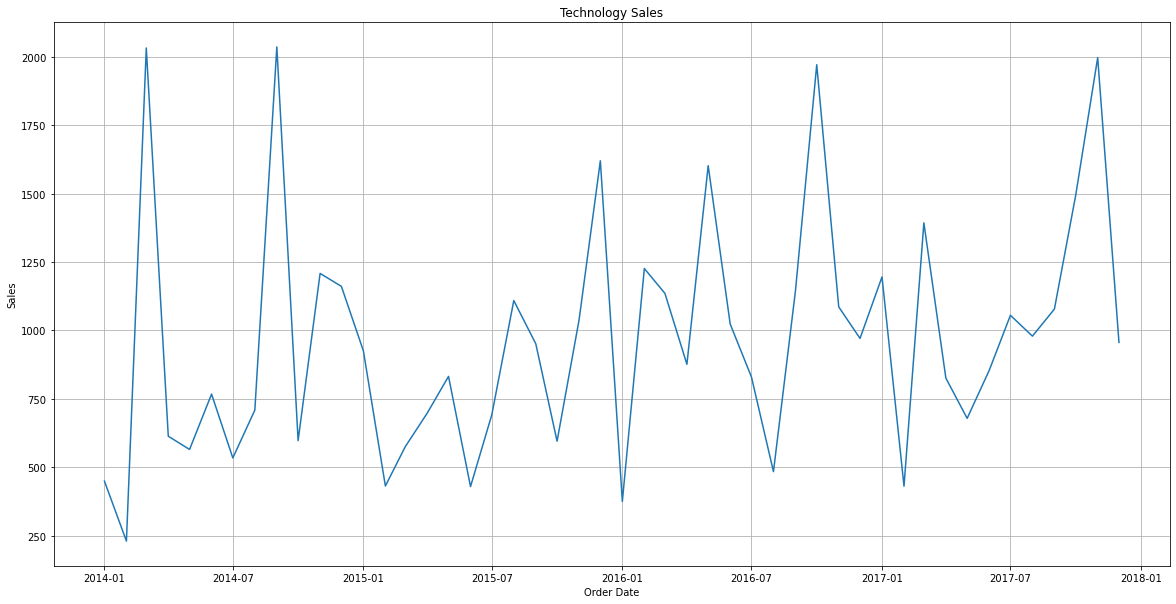

In [11]:
#Visualizing technology dales time series data
#Generate graph
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(y)
plt.title('Technology Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

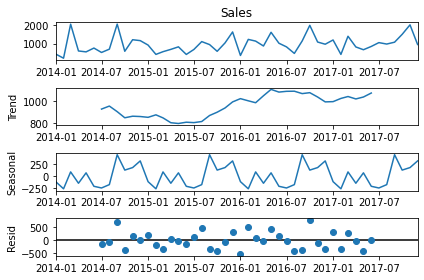

In [12]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [13]:
#plot ACF
#plot_acf(y, lags=range(1,12), alpha=0.1);

In [14]:
#plot PACF
#plot_pacf(y, lags=range(1,12), alpha=0.1);

In [15]:
#Check for stationarity using ADF test
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
    

result = adfuller(y, maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.187969e+00
P-Value                 2.547334e-10
# Lags Used             0.000000e+00
# Observations Used     4.700000e+01
Critical Value (1%)    -3.577848e+00
Critical Value (5%)    -2.925338e+00
Critical Value (10%)   -2.600774e+00
dtype: float64


# Model development
1st = SARIMA model,
2nd = LSTM model,
3rd = CNN model

# 1st: SARIMA model

In [16]:
#SARIMA
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [17]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:791.4891765009955
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1458.2326432259838
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:549.0156237882128
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:356.4725519398159
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:564.1031529698098
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1360.3492284912968
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:372.6612068172691
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:357.88452536958295
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:750.8969484750888
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2737.899890505949
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:535.0489454746778
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:341.1892359670155
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:566.0827904028181
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2655.4802067650053
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:373.8760065868629
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:342.6307363419631
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:729.3478530237927
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1336.0985178535898
ARIMA

In [18]:
sarimax = SARIMAX(y, order=(0,1,1), seasonal_order=(0,1,1,12)).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -268.540
Date:                            Thu, 01 Apr 2021   AIC                            543.080
Time:                                    12:02:47   BIC                            547.746
Sample:                                01-01-2014   HQIC                           544.690
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9980     12.053     -0.083      0.934     -24.621      22.625
ma.S.L12      -0.9873     17.414     -0.057      0.955     -35.119      33.144
sigma2       1.73e+05    3.2e+06      0.054      0.957    -6.1e+06    6.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 0.40
Prob(Q):                              0.41   Prob(JB):                         0.82
Heteroskedasticity (H):               0.63   Skew:                             0.25
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

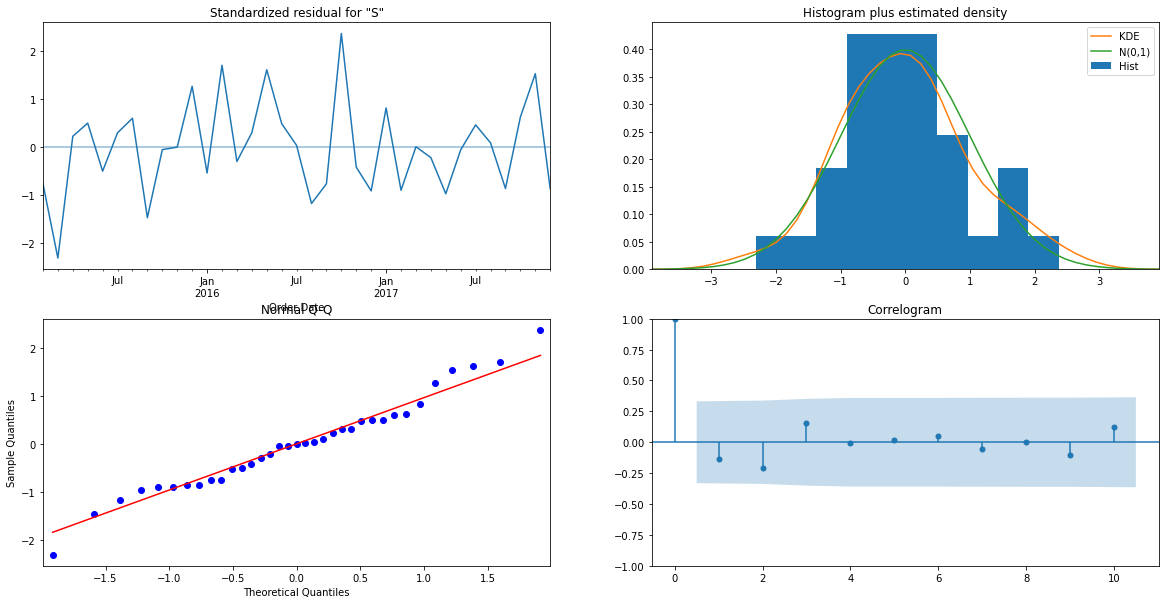

In [19]:
sarimax.plot_diagnostics(figsize=(20, 10))
plt.show()

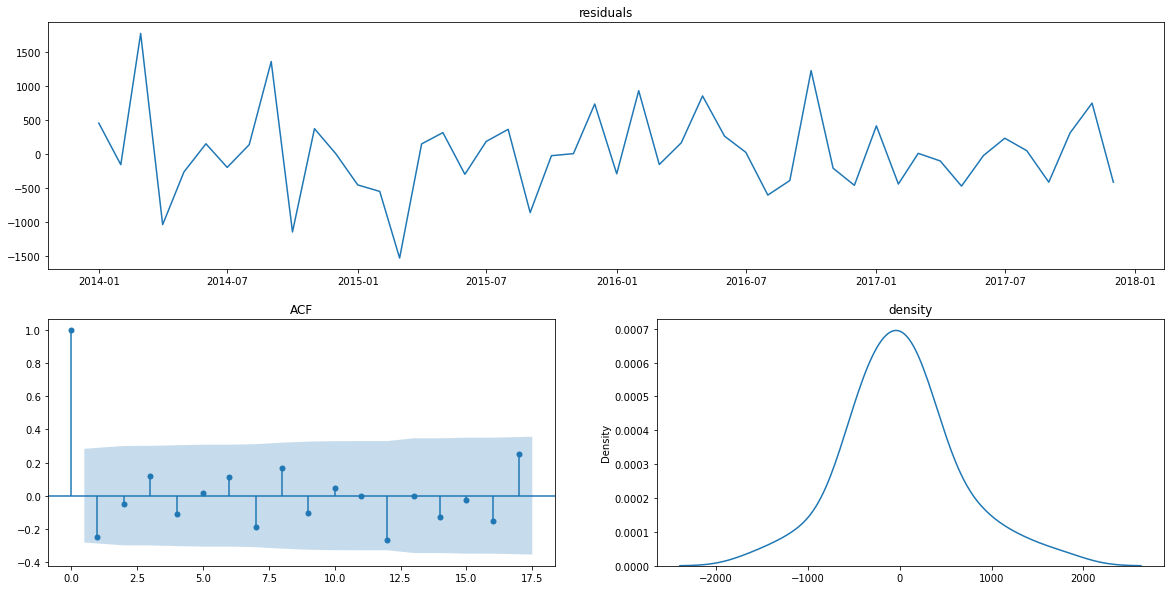

In [20]:
residuals =pd.Series(sarimax.resid)
def check_residuals(series):
    fig = plt.figure(figsize=(20, 10))    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(series)
    ax1.set_title('residuals')
    
    ax2 = fig.add_subplot(gs[1,0])
    plot_acf(series, ax=ax2, title='ACF')
    
    ax3 = fig.add_subplot(gs[1,1])
    sns.kdeplot(series, ax=ax3)
    ax3.set_title('density')
    
    plt.show()
    
check_residuals(residuals)

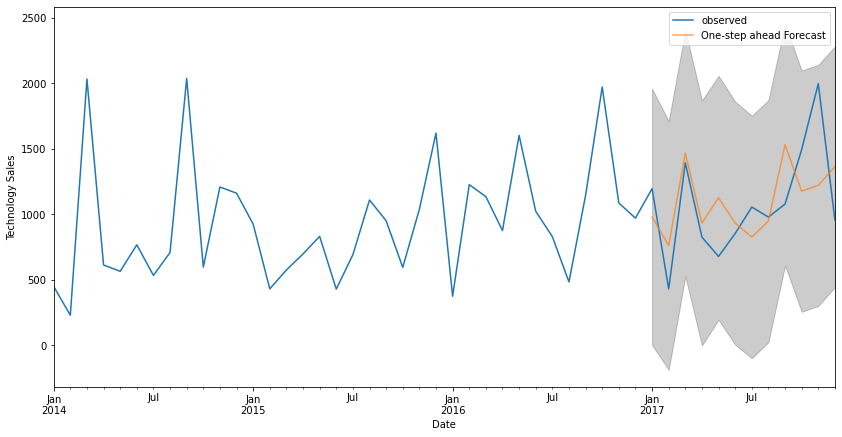

In [21]:
#Compare forecast data and observed data with SARIMA
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Technology Sales')
plt.legend()
plt.show()

In [22]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
#print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 354.18


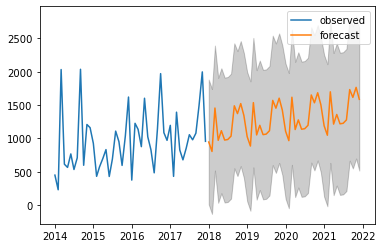

In [23]:
#Forecast sales for future years
sarimax_forecast = sarimax.get_forecast(48)
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

plt.plot(y, label='observed')
plt.plot(sarimax_forecast.predicted_mean, label='forecast')


plt.fill_between(sarimax_forecast_conf_int.index,
                 sarimax_forecast_conf_int.iloc[:, 0],
                 sarimax_forecast_conf_int.iloc[:, 1], color='k', alpha=.2)

plt.legend()

# 2nd: LSTM model

In [24]:
#LSTM
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
from matplotlib.lines import Line2D
from torchsummaryX import summary

# To auto load the customise module
%load_ext autoreload
%autoreload 2
import deep_learning_module
import data_module

In [25]:
#Set hyperparameters
num_epochs = 100
split_ratio = 0.70
batch_size = 2
window_size = 2
n_step = 2

In [26]:
#Split data by indexing
split_data = round(len(y)*split_ratio)
split_data

34

In [27]:
#Data spliting
train_data = y[:split_data]
test_data = y[split_data:]
train_time = train_data.index
test_time = test_data.index
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(34,)
test_data_shape
(14,)


In [28]:
#Data standardization
scaler = StandardScaler().fit(train_data.values.reshape(-1,1))
scaler_train_data = scaler.transform(train_data.values.reshape(-1,1))
scaler_test_data = scaler.transform(test_data.values.reshape(-1,1))

In [29]:
print(f"scaler_train_data shape : {scaler_train_data.shape}")
print(f"scaler_test_data shape : {scaler_test_data.shape}")

scaler_train_data shape : (34, 1)
scaler_test_data shape : (14, 1)


In [30]:
#Data sequencing
trainX ,trainY =  data_module.univariate_multi_step(scaler_train_data,window_size,n_step)
testX , testY = data_module.univariate_multi_step(scaler_test_data,window_size,n_step)

print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}")
print(f"testX shape:{testX.shape} testX shape:{testY.shape}")

trainX shape:(31, 2, 1) trainY shape:(31, 2, 1)
testX shape:(11, 2, 1) testX shape:(11, 2, 1)


In [31]:
def key_assign(trainingX,testingX,trainingY,testingY):
    """ 
    Use to assign  the key to create the train_data_dict and test_data_dict   
    Arguments:
    trainingX -- feature for traning data 
    testingX -- feature for testing data
    trainingY -- label for traning data
    testingY -- label for testing data   
    Returns: 
    train_data_dict -- dictionary of trainingX and trainingY
    test_data_dict -- dictionary of testingX and testingY
    """    
    # Create a dictionary that can store the train set feature and label
    train_data_dict = {"train_data_x_feature" : trainingX, "train_data_y_label" : trainingY}
    
    # Create a dictionary that can store the test set feature and label
    test_data_dict  = {"test_data_x_feature" : testingX , "test_data_y_label" : testingY }

    return train_data_dict , test_data_dict

train_data_dictionary , test_data_dictionary = key_assign(trainingX = trainX,
                                 testingX = testX,
                                 trainingY = trainY,
                                 testingY = testY)

In [32]:
def transform(train_data_dict, test_data_dict):
    """ 
    Transform the NumPy data to torch tensor    
    Arguments:
    train_data_dict -- train data dictionary 
    test_data_dict -- test data dictionary    
    Returns: 
    train_data_dict -- train data dictionary 
    test_data_dict -- test data dictionary
    """
    for train_datapoint in train_data_dict:
        train_data_dict[train_datapoint] =  torch.from_numpy(train_data_dict[train_datapoint]).type(torch.Tensor)
        
    for test_datapoint in test_data_dict:
        test_data_dict[test_datapoint] = torch.from_numpy(test_data_dict[test_datapoint]).type(torch.Tensor)

    return train_data_dict,test_data_dict

train_data_dictionary,test_data_dictionary = transform(train_data_dictionary,test_data_dictionary)

In [33]:
def sanity_check(data_1,data_2):
    """ 
    Print the shape of data_1 and data_2    
    Arguments:
    data_1 -- (dict) type of data
    data_2 -- (dict) type of data 
    """
    for key_1 in data_1:
        print(key_1 +" shape : " + str(data_1[key_1].shape))
    for key_2 in data_2:
        print(key_2 +" shape : " + str(data_2[key_2].shape))

In [34]:
#Sanity check
sanity_check(train_data_dictionary,test_data_dictionary)

train_data_x_feature shape : torch.Size([31, 2, 1])
train_data_y_label shape : torch.Size([31, 2, 1])
test_data_x_feature shape : torch.Size([11, 2, 1])
test_data_y_label shape : torch.Size([11, 2, 1])


In [35]:
#Create Iterator
def iterator(train_data_dict,test_data_dict,batch_size):
    """ 
    Create iterator for train data and test data     
    Arguments:
    train_data_dict -- train data dictionary 
    test_data_dict -- test data dictionary    
    Returns: 
    train_iter -- train data iterator 
    test_iter -- test data iterator 
    """
    train_dataset = TensorDataset(train_data_dict["train_data_x_feature" ],
                                  train_data_dict["train_data_y_label"])
    train_iter = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

    test_dataset = TensorDataset(test_data_dict["test_data_x_feature"],
                                 test_data_dict["test_data_y_label"])
    test_iter = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    
    return train_iter , test_iter

train_iter , test_iter = iterator(train_data_dictionary,test_data_dictionary,batch_size)

In [36]:
#LSTM Configuration
# seed
torch.manual_seed(123)

#Arguments for LSTM model
hidden_dim = 1
n_feature = 1 

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1 

#Vanila , Stacked LSTM
model = deep_learning_module.LSTM(n_feature = n_feature ,
                         hidden_dim = hidden_dim ,
                         num_layers = num_layers,
                         n_step = n_step)
#loss function 
loss_fn = torch.nn.MSELoss()

#optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
inputs = torch.zeros((batch_size,window_size,1),dtype=torch.float) # batch size , seq_length , input_dim
print(summary(model,inputs))

       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -    [2, 2, 1]      16          8
1_fc         [1, 2]       [2, 2]       4          2
---------------------------------------------------
                      Totals
Total params              20
Trainable params          20
Non-trainable params       0
Mult-Adds                 10
       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -    [2, 2, 1]      16          8
1_fc         [1, 2]       [2, 2]       4          2


In [38]:
#Start Training 
torch.manual_seed(123)
train_loss,val_loss = deep_learning_module.training(num_epochs,train_iter,test_iter,optimizer,loss_fn,model)

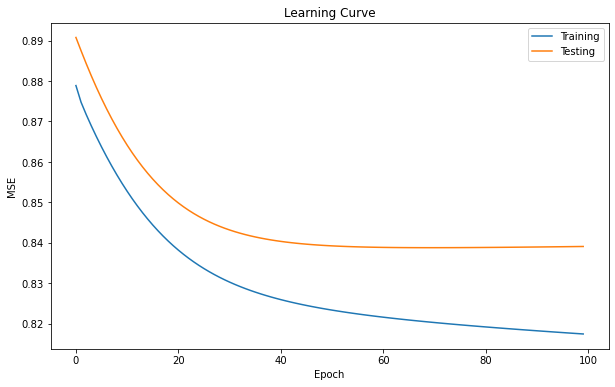

Epoch : 0 , training loss : 0.8788716312377683 , validation loss : 0.8907578695904125
Epoch : 1 , training loss : 0.8747560189616296 , validation loss : 0.8874820917844772
Epoch : 2 , training loss : 0.871727547337932 , validation loss : 0.8843088678338311
Epoch : 3 , training loss : 0.8689125997404898 , validation loss : 0.8812784268097444
Epoch : 4 , training loss : 0.866240200496489 , validation loss : 0.8783984238451178
Epoch : 5 , training loss : 0.8636963348234853 , validation loss : 0.8756685135039416
Epoch : 6 , training loss : 0.8612757325172424 , validation loss : 0.8730859011411667
Epoch : 7 , training loss : 0.8589745990691646 , validation loss : 0.8706468885595148
Epoch : 8 , training loss : 0.8567892389912759 , validation loss : 0.868347289210016
Epoch : 9 , training loss : 0.8547160221684363 , validation loss : 0.8661824275146831
Epoch : 10 , training loss : 0.8527510920839925 , validation loss : 0.8641478297385302
Epoch : 11 , training loss : 0.8508907402715375 , valida

In [39]:
data_module.learning_curve(num_epochs,train_loss,val_loss)

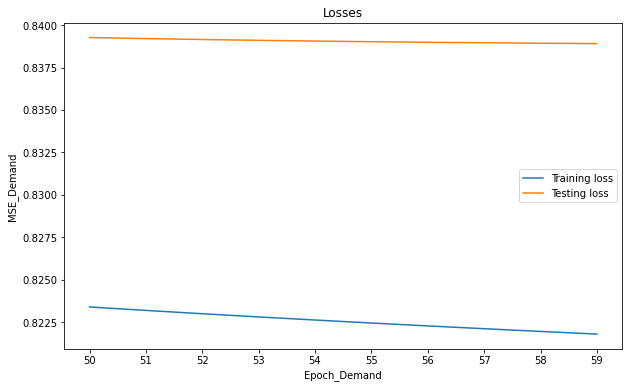

In [40]:
data_module.zoom_learning_curve(start_epoch = 50,
                                end_epoch =60 ,
                                training_loss = train_loss,
                                validation_loss = val_loss)

In [41]:
#Evaluation
#Section 1 : Feed in the train and test data to the model
with torch.no_grad():
    y_train_prediction = model(train_data_dictionary["train_data_x_feature"])
    y_test_prediction = model(test_data_dictionary["test_data_x_feature"])
    
def key_assign_evaluation(y_train_prediction,
                          y_test_prediction,
                          train_data_dictionary,
                          test_data_dictionary):
    """ 
    Assign key for prediction and output data dictionary     
    Arguments:
    y_train_prediction -- (tensor) prediction for training data
    y_test_prediction -- (tensor) prediction for test data
    train_data_dictionary -- (dict) train data dictionary
    test_data_dictionary -- (dict) test data dictionary        
    Returns: 
    prediction -- (dict) dictionary that consists of prediction from train data and test data
    output_data -- (dict) dictionary that consists of output(label) from train data and test data
    """
    prediction ={"train_data_prediction" : y_train_prediction,
            "test_data_prediction" :y_test_prediction }
    output_data ={"train_data_output" : train_data_dictionary["train_data_y_label"] ,
               "test_data_output" : test_data_dictionary["test_data_y_label"]}
    
    return prediction , output_data

prediction , output_data = key_assign_evaluation(y_train_prediction,y_test_prediction,
                                                 train_data_dictionary,
                                                 test_data_dictionary)     

#Check the prediction and output shape
sanity_check(data_1 = prediction,data_2 = output_data)

train_data_prediction shape : torch.Size([31, 2])
test_data_prediction shape : torch.Size([11, 2])
train_data_output shape : torch.Size([31, 2, 1])
test_data_output shape : torch.Size([11, 2, 1])


In [42]:
#Section 2 : Reshape both to the original data dimension
def squeeze_dimension(output):
    """ 
    Squeeze the dimension of output data    
    Arguments:
    output -- (dict) output_data    
    Returns: 
    output_data -- (dict) output_data
    """
    for key in output:
        output[key] = torch.squeeze(output[key],2)

    return output

output_data = squeeze_dimension(output_data)

#Check the output shape
sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([31, 2])
test_data_output shape : torch.Size([11, 2])


In [43]:
#Section 3 : Invert the scaling back to orignal data value
def inverse_scaler(scaled_data,scaler):
    """ 
    Inverse the scaled data    
    Arguments:
    scaled_data -- (dict) data that being scaled 
    scaler -- scaler     
    Returns: 
    scaled_data -- (dict) data after inverse scale
    """
    for item in scaled_data:
        scaled_data[item] =  scaler.inverse_transform(scaled_data[item].detach().numpy())

    return scaled_data
    
prediction = inverse_scaler(prediction,scaler)
output_data  = inverse_scaler(output_data ,scaler)

sanity_check(data_1 = prediction,data_2 = output_data )

train_data_prediction shape : (31, 2)
test_data_prediction shape : (11, 2)
train_data_output shape : (31, 2)
test_data_output shape : (11, 2)


In [44]:
def list_forecast_value(output_data,prediction):
    """ 
    To list the test output and prediction output side by side    
    Arguments:
    output_data --  (dict) output data dictionary
    prediction -- (dict) prediction output dictionary
    """
    print("Test Data\t\t\tForecast")
    for test, forecast in zip(output_data["test_data_output"],prediction["test_data_prediction"]):   
        print(f"{test}\t\t{forecast}")
        
list_forecast_value(output_data,prediction)  

Test Data			Forecast
[1195.218   430.5017]		[936.56824 961.5375 ]
[ 430.5017 1392.8593]		[932.6941 965.0521]
[1392.8593   825.55914]		[944.0183 954.7787]
[825.55914 678.3294 ]		[940.6209  957.86084]
[678.3294 853.055 ]		[933.12805 964.65845]
[ 853.055  1054.9966]		[950.2672 949.1097]
[1054.9966   978.84235]		[950.52264 948.8779 ]
[ 978.84235 1077.7041 ]		[940.3479 958.1085]
[1077.7041 1493.4392]		[937.1337 961.0244]
[1493.4392 1996.7509]		[936.2039 961.868 ]
[1996.7509   955.86566]		[919.9642  976.60077]


In [45]:
#Section 4 : Calculate the RMSE of train and test data
def rmse(prediction,output_data):
    """ 
    Calculate RMSE between output data and prediction data     
    Arguments:
    prediction -- (dict) prediction output dictionary
    output_data --  (dict) output data dictionary    
    Returns:
    trainScore - RMSE of train dataset
    testScore - RMSE of test dataset
    """
    trainScore = math.sqrt(mean_squared_error(prediction["train_data_prediction"], output_data["train_data_output"]))
    testScore = math.sqrt(mean_squared_error(prediction["test_data_prediction"], output_data["test_data_output"]))
    return trainScore,testScore

trainScore,testScore = rmse(prediction,output_data)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 424.14 RMSE
Test Score: 429.79 RMSE


In [46]:
plot_details ={"x-axis" : "Order Date",
          "y-axis" : "Sales",
          "title"  : "Technology Sales"
         }

In [47]:
# Plot forecast plot for multi-step
def multi_step_plot(original_test_data,
                    after_sequence_test_data ,
                    forecast_data,test_time,window_size,
                    n_step ,
                    details = {},
                    original_plot = False):
    
    """ 
    Plot the result of the multi-step forecast    
    Arguments:    
    original_test_data -- test data before sequence    
    after_sequence_test_data -- (dict) output data dictionary   
    forecast_data -- (dict) prediction data dictionary    
    test_time --  time index for test data before sliding window (data sequence)    
    window_size -- window size for the data sequence    
    n_step -- the number of future step , 1 -> single >1 -> multi-step    
    details -- (dict) details for plot such as "x-axis" ,"y-axis", "title"    
    original_plot -- (boolean) True ->observe how sliding window (data sequence) take place in the test data    
    """
    
    after_sequence_test_data = after_sequence_test_data['test_data_output'] 
    forecast_data = forecast_data["test_data_prediction"]
    
    # Plot Setting
    plt.figure(figsize=(10,6))
    plt.xticks(rotation=45)    
    
    # Store test and forecast data into DataFrame type 
    column_names = ["timestep_" + str(i) for i in range(after_sequence_test_data.shape[1])]
    y_test_dataframe = pd.DataFrame(after_sequence_test_data,columns = column_names)
    y_test_pred_dataframe =pd.DataFrame(forecast_data,columns = column_names)
    
    # Create time index for data after sequence
    time_index_after_sequence = test_time[window_size:]
    
    # Test Data plot before sliding window(data sequencing)
    if original_plot:
        plt.plot(test_time,original_test_data,marker='x',color="blue")

    # For loop to plot the data step by step base on time index    
    start_idx = 0 
    for row in range(len(y_test_dataframe)):
        
        # Iterate the time index after sequence
        time_index = time_index_after_sequence[start_idx:start_idx+n_step]
        
        # Plot the test data
        plt.plot(time_index,y_test_dataframe.iloc[row],color="green",marker='o')
        
        # Plot the forecast data
        plt.plot(time_index,y_test_pred_dataframe.iloc[row],color="red",marker='o')
        
        # Pointer for time_index_after_sequence
        start_idx += 1
        
    # Customize the legend
    custom_lines = [Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="blue", lw=4)]
    plt.legend(custom_lines, ['Test Data After Sequencing', 'Forecast Data', 'Test Data Before Sequencing'])
    
    # Extra details - Optional function
    if details != {}:
        plt.xlabel(details["x-axis"])
        plt.ylabel(details["y-axis"])
        plt.title(details["title"])
    

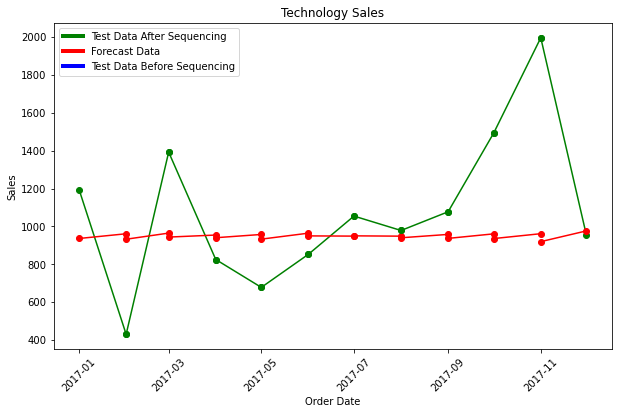

In [48]:
# Use the multi_step_plot function
multi_step_plot(original_test_data = test_data,
                after_sequence_test_data = output_data ,
                forecast_data = prediction,
                test_time = test_time,
                window_size = window_size ,
                n_step = n_step,
                details = plot_details,
                original_plot = False)

# 3rd: CNN model

In [49]:
# import packages needed
import torch.nn.functional as F
import matplotlib.dates as mdates 

In [50]:
#Hyperparameter/Data spliting/Data Standardization - mostly reuse form lstm model
learning_rate = 0.05

In [51]:
#Data Transform
train_data_dictionary ,test_data_dictionary = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)

train_data_dictionary ,test_data_dictionary = data_module.transform(train_data_dictionary ,test_data_dictionary)

#Sanity check
data_module.sanity_check(train_data_dictionary , test_data_dictionary)

train_data_x_feature shape : torch.Size([31, 2, 1])
train_data_y_label shape : torch.Size([31, 2, 1])
test_data_x_feature shape : torch.Size([11, 2, 1])
test_data_y_label shape : torch.Size([11, 2, 1])


In [52]:
#Data Transpose
train_data_dictionary , test_data_dictionary = data_module.transpose(train_data_dictionary, test_data_dictionary)

#Sanity check
data_module.sanity_check(train_data_dictionary , test_data_dictionary)

train_data_x_feature shape : torch.Size([31, 1, 2])
train_data_y_label shape : torch.Size([31, 2, 1])
test_data_x_feature shape : torch.Size([11, 1, 2])
test_data_y_label shape : torch.Size([11, 2, 1])


In [53]:
# Create Iterator
train_iter , test_iter = data_module.iterator(train_data_dictionary,
                                              test_data_dictionary,
                                              batch_size = batch_size)

In [54]:
#CNN configuration
# seed
torch.manual_seed(123)

n_feature = train_data_dictionary['train_data_x_feature'].shape[1]

# Input the attribute need by the model 
model = deep_learning_module.CNN(n_feature = n_feature,
                        n_step = n_step )

# Define the optimizer (Here we use Adam as our optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function (Here we use MSE as the loss function)
loss_fn = nn.MSELoss()

In [55]:
seq_length = train_data_dictionary['train_data_x_feature'].shape[2]

# batch size ,input_dim ,seq_length
inputs = torch.zeros((batch_size,
                      n_feature,
                      seq_length),dtype=torch.float) 

print(summary(model,inputs))

        Kernel Shape Output Shape Params Mult-Adds
Layer                                             
0_conv1   [1, 30, 1]   [2, 30, 2]   60.0      60.0
1_poo1             -   [2, 30, 2]      -         -
2_conv2  [30, 20, 1]   [2, 20, 2]  620.0      1.2k
3_pool2            -   [2, 20, 1]      -         -
4_fc1       [20, 10]      [2, 10]  210.0     200.0
5_fc2        [10, 2]       [2, 2]   22.0      20.0
----------------------------------------------------
                      Totals
Total params           912.0
Trainable params       912.0
Non-trainable params     0.0
Mult-Adds              1.48k
        Kernel Shape Output Shape  Params  Mult-Adds
Layer                                               
0_conv1   [1, 30, 1]   [2, 30, 2]    60.0       60.0
1_poo1             -   [2, 30, 2]     NaN        NaN
2_conv2  [30, 20, 1]   [2, 20, 2]   620.0     1200.0
3_pool2            -   [2, 20, 1]     NaN        NaN
4_fc1       [20, 10]      [2, 10]   210.0      200.0
5_fc2        [10, 2]   

In [56]:
# seed
torch.manual_seed(123)

#  Xavier Weight Initialize 
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

CNN(
  (conv1): Conv1d(1, 30, kernel_size=(1,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(1,), stride=(1,))
  (pool2): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [57]:
#Training
# seed
torch.manual_seed(123)
# Start Training
train_loss, val_loss = deep_learning_module.training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

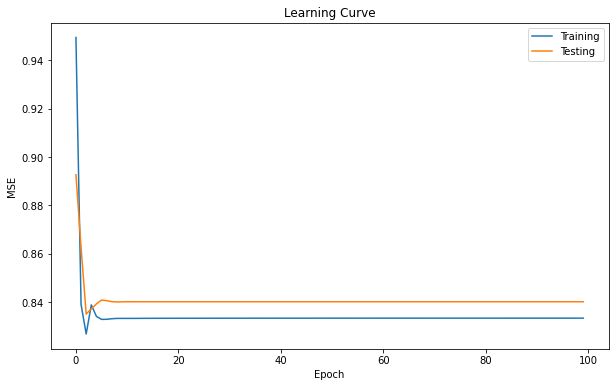

Epoch : 0 , training loss : 0.9494095194724298 , validation loss : 0.8926235816695474
Epoch : 1 , training loss : 0.8389904873986398 , validation loss : 0.8626454770565033
Epoch : 2 , training loss : 0.8267880332085394 , validation loss : 0.8350098525935953
Epoch : 3 , training loss : 0.8388186433622914 , validation loss : 0.8372007960622961
Epoch : 4 , training loss : 0.8340500131730111 , validation loss : 0.8392230170694265
Epoch : 5 , training loss : 0.8328289178109938 , validation loss : 0.8408219584009864
Epoch : 6 , training loss : 0.8328511628412432 , validation loss : 0.8405702879483049
Epoch : 7 , training loss : 0.8330933576630007 , validation loss : 0.8401397940787402
Epoch : 8 , training loss : 0.8332193955298393 , validation loss : 0.8400280800732699
Epoch : 9 , training loss : 0.8332362790261546 , validation loss : 0.8400771374052222
Epoch : 10 , training loss : 0.8332297936562569 , validation loss : 0.8401188267902895
Epoch : 11 , training loss : 0.8332323883810351 , val

In [58]:
#Validation
data_module.learning_curve(num_epochs = num_epochs , train_loss = train_loss , val_loss = val_loss )

In [59]:
#Evaluation
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(train_data_dictionary['train_data_x_feature'])
    y_test_prediction = model(test_data_dictionary['test_data_x_feature'])

In [60]:
# Assign evaluation key

prediction , output = data_module.key_assign_evaluation(y_train_prediction,
                                                        y_test_prediction,
                                                        train_data_dictionary,
                                                        test_data_dictionary)
# Section 2 : Reshape to original data
# Squeeze the output dimension
output_data = data_module.squeeze_dimension(output)

#sanity check
data_module.sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([31, 2])
test_data_output shape : torch.Size([11, 2])


In [61]:
# Section 3 : Invert the scaling back to the original data value
prediction = data_module.inverse_scaler(prediction,scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler)

#sanity check
data_module.sanity_check(data_1 = prediction,data_2 = output_data )

train_data_prediction shape : (31, 2)
test_data_prediction shape : (11, 2)
train_data_output shape : (31, 2)
test_data_output shape : (11, 2)


In [62]:
# List the forecast value
data_module.list_forecast_value(output_data,prediction) 

Test Data			Forecast
[1195.218   430.5017]		[931.72504 957.4926 ]
[ 430.5017 1392.8593]		[931.72504 957.4926 ]
[1392.8593   825.55914]		[931.72504 957.4926 ]
[825.55914 678.3294 ]		[931.72504 957.4926 ]
[678.3294 853.055 ]		[931.72504 957.4926 ]
[ 853.055  1054.9966]		[931.72504 957.4926 ]
[1054.9966   978.84235]		[931.72504 957.4926 ]
[ 978.84235 1077.7041 ]		[931.72504 957.4926 ]
[1077.7041 1493.4392]		[931.72504 957.4926 ]
[1493.4392 1996.7509]		[931.72504 957.4926 ]
[1996.7509   955.86566]		[931.72504 957.4926 ]


In [63]:
# Section 4 : Calculate the RMSE of train and test data
trainScore,testScore = data_module.rmse(prediction,output_data)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 426.13 RMSE
Test Score: 430.05 RMSE


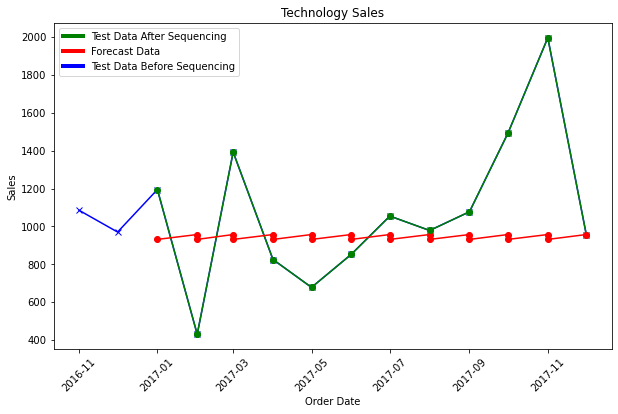

In [64]:
#Plot forecast graph
plot_details ={"x-axis" : "Order Date",
          "y-axis" : "Sales",
          "title"  : "Technology Sales"
         }
# Use the multi_step_plot function
data_module.multi_step_plot(original_test_data = test_data,
                after_sequence_test_data = output_data ,
                forecast_data = prediction,
                test_time = test_time,
                window_size = window_size ,
                n_step = n_step,
                details = plot_details,
                original_plot = True)